In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

plt.rcParams['figure.figsize'] = [5.0, 4.0]
plt.rcParams['figure.dpi'] = 120

# Loading data

In [27]:
X_train_full = pd.read_csv('data\\training_set_features.csv', index_col = 'respondent_id')
y_train_full = pd.read_csv('data\\training_set_labels.csv', index_col = 'respondent_id')

Joining X and y for plotting simplicity:

In [28]:
train_df = X_train_full.join(y_train_full)

In [29]:
X_test = pd.read_csv('data\\test_set_features.csv', index_col = 'respondent_id')

# Exploratory Data Analysis

In this notebook, we want to explore the data through statistics and visualizations that help us draw insight from the raw data which can then be applied to preprocessing and feature engineering to help increase the accuracy of our predictions.

Lets begin by dividing the features in *numerical* and *categorical* since these require different approaches to visualization:

In [30]:
categorical_cols = [col for col in X_train_full.columns if X_train_full[col].dtype == 'object']
numerical_cols = [col for col in X_train_full.columns if col not in categorical_cols]
target_cols = ['h1n1_vaccine', 'seasonal_vaccine']

We can immediately plot the distribution of the targets and the numerical features:

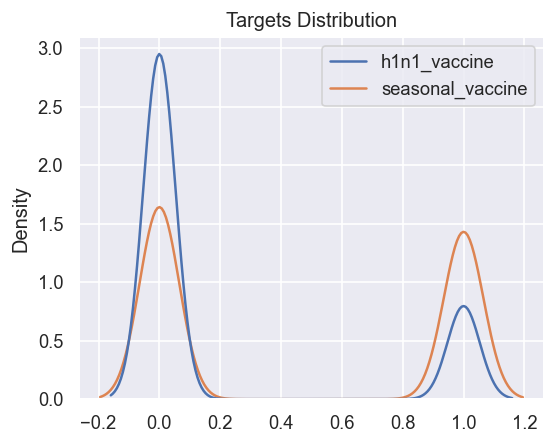

In [31]:
plt.figure()
plt.title('Targets Distribution')
sns.kdeplot(data=y_train_full);

From this image we can immediately see that someone is more likely to not take the H1N1 vaccine that to take it.

We can also see that the probability of taking the seasonal flu vaccine is more uniformly distributed.

Now we can start plotting the features.

Lets begin with the distribution of some categorical features for each of the targets. For that, we use the function:

In [32]:
def plot_bars(cols_to_plot, figsize = (8, 20)):
    fig, axs = plt.subplots(len(cols_to_plot), 2, figsize = figsize)
    for i, col in enumerate(cols_to_plot):
        for j, target in enumerate(target_cols):
            counts = train_df[[target, col]].groupby([target, col]).size().unstack(target)
            counts_group = counts.sum(axis = 'columns')
            counts_percentage = counts.div(counts_group, axis = 'index')

            ax = axs[i][j]
            counts_percentage.plot(kind="barh", stacked=True, ax=ax, label = f'{target}')
            ax.invert_yaxis()
            ax.legend().remove()
            
        plt.tight_layout()
        axs[0][0].legend(loc = 'lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
        axs[0][1].legend(loc = 'lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')        

We want to replace some data names so that the plots have simpler axis labels:

In [33]:
train_df['age_group'].replace('65+ Years', '65+', inplace = True)
train_df['age_group'].replace('55 - 64 Years', '55+', inplace = True)
train_df['age_group'].replace('45 - 54 Years', '45+', inplace = True)
train_df['age_group'].replace('35 - 44 Years', '35+', inplace = True)
train_df['age_group'].replace('18 - 34 Years', '18+', inplace = True)

In [34]:
train_df['education'].replace('College Graduate', 'Very High', inplace = True)
train_df['education'].replace('Some College', 'High', inplace = True)
train_df['education'].replace('12 Years', 'Medium', inplace = True)
train_df['education'].replace('< 12 Years', 'Low', inplace = True)

In [35]:
train_df['income_poverty'].replace('Below Poverty', 'Low', inplace = True)
train_df['income_poverty'].replace('<= $75,000, Above Poverty', 'Medium', inplace = True)
train_df['income_poverty'].replace('> $75,000', 'High', inplace = True)

In [36]:
train_df['employment_status'].replace('Not in Labor Force', 'Not Working', inplace = True)

In [37]:
train_df['census_msa'].replace('MSA, Not Principle  City', 'NoPrinc.', inplace = True)
train_df['census_msa'].replace('MSA, Principle City', 'Princ.', inplace = True)

Finally, we choose the columns to plot. Notice we left out the columns *hhs_geo_region* and *employment_industry/occupation* since the data is coded and we probably wouldn't get much information from the plots.

In [38]:
cols_to_plot = ['age_group',
                'education',
                'race',
                'sex',
                'income_poverty',
                'marital_status',
                'rent_or_own',
                'employment_status',
                'census_msa']

And we make the plots:

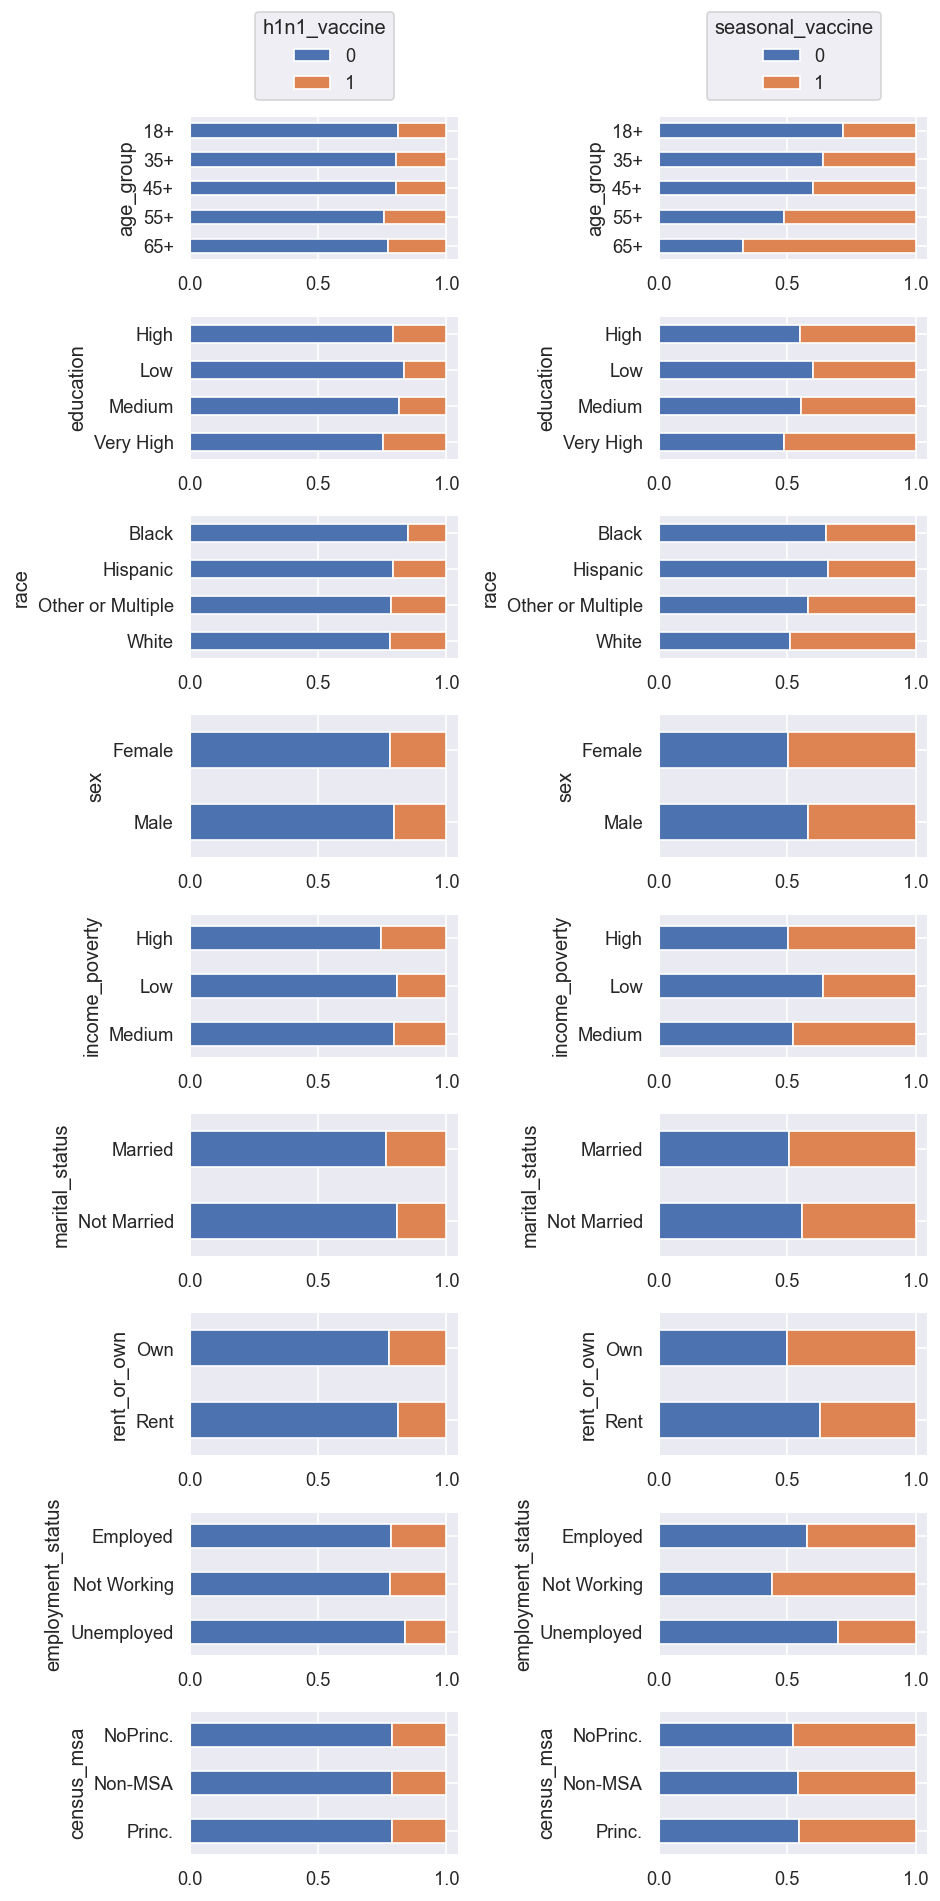

In [39]:
plot_bars(cols_to_plot, figsize = (8, 16))

We can draw some insights from this figure:
* The *age_group* feature shows that older people tended to get the seasonal vaccine more often than younger people - which is expected since people of higher age groups tend to be more affected and have more complications due to the flu. This correlation is not so obvious with the H1N1 vaccine.
* *education* seems to also be related to taking the vaccines - both the seasonal and the H1N1. This can possibly be attributed to more information about the deseases and the vaccines and thus a higher probability of wanting to protect themselves.
* Economic features such as *income_poverty* and *rent_or_own* show some correlation between a higher income and taking the vaccines - even though this is more prevalent in the case of the seasonal vaccine, it can also be minimally observed for the H1N1 vaccine.

These conclusions make me think that we should encode some features such as *education*, *income_poverty* and even, maybe, *age_group* as ordinal variables instead of the simple *OneHotEncoding* that we were using.

We can now begin analysing the numerical columns.
We see that we can make some groups of features that belong in the same plot and the same analysis, such as:
* *behavioral_...*
* *opinion_...*
* *doctor_recc_...*
* *h1n1_concern/knowledge*
* demographics - *household_adults*, *household_children*, *child_under_6_months*

In [41]:
behavioral_cols = ['behavioral_antiviral_meds',
                   'behavioral_avoidance',
                   'behavioral_face_mask',
                   'behavioral_wash_hands',
                   'behavioral_large_gatherings',
                   'behavioral_outside_home',
                   'behavioral_touch_face']

In [42]:
train_df['general_behavior'] = pd.Series(np.zeros(train_df.shape[0]), index = train_df.index)
for b_col in behavioral_cols:
    train_df['general_behavior'] += train_df[b_col]

behavioral_cols.append('general_behavior')

engineered_features = ['general_behavior']

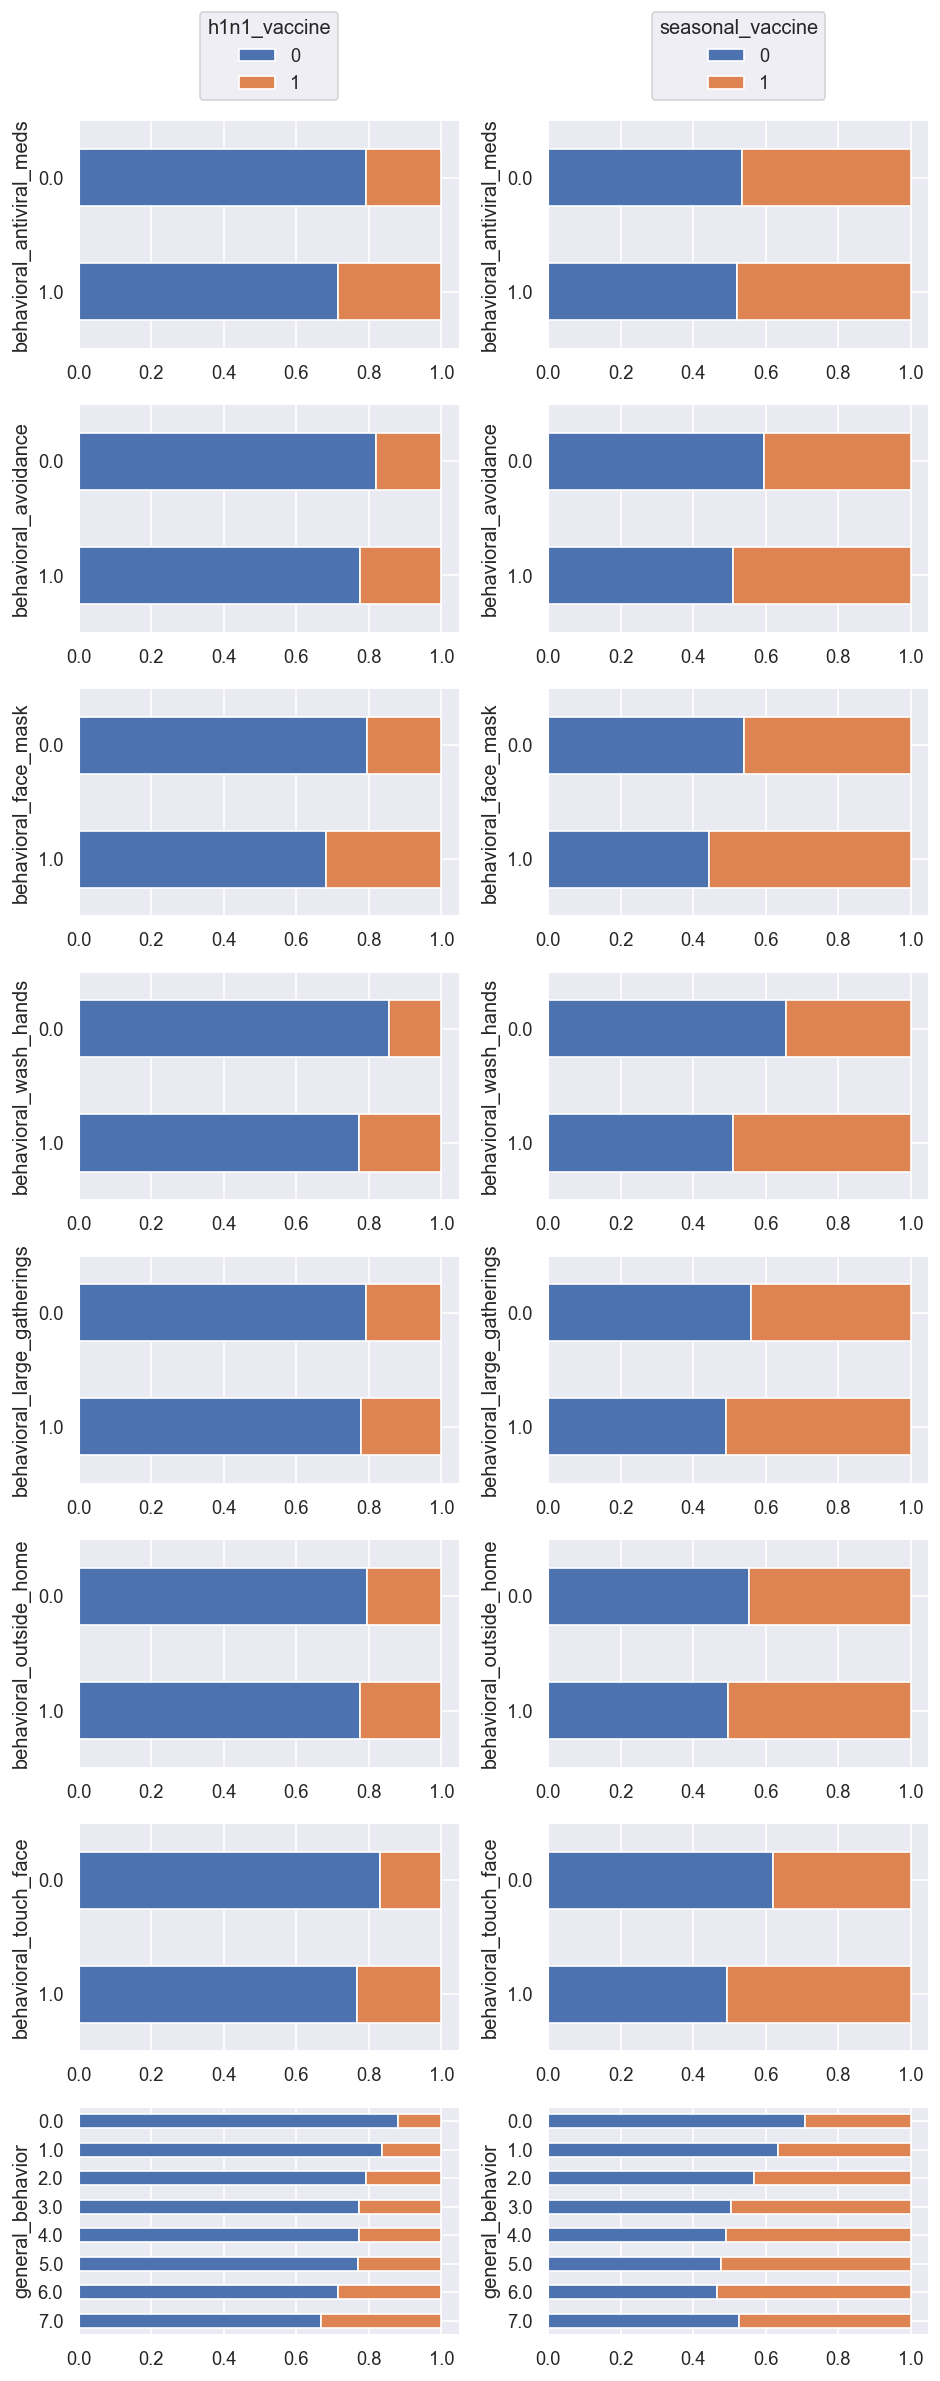

In [43]:
plot_bars(behavioral_cols)

Analysing the plots for the behavioural variables we can see that, for all variables and for both the H1N1 and seasonal flu, people who avoid risky behaviours - those who have answered *1* in these features - tend to get the vaccine more than those who do not avoid risky behaviours. This can be counter-intuitive since, by avoiding risky behaviours, one would be more protected from the diseases and one could think that the vaccine is no longer as required. However, the opposite happens. I theorize that this could be associated with a higher concern and information about the diseases.

This information could be used to engineer a *general_behaviour* feature which would be the sum of all these behavioural features and would represent the general behaviour of a person towards protecting themselves from the diseases. This feature does seem to be correlated with taking the vaccine, so we will keep it.

In [44]:
opinion_cols = ['opinion_h1n1_vacc_effective',
                'opinion_seas_vacc_effective',
                'opinion_h1n1_risk',
                'opinion_seas_risk',
                'opinion_h1n1_sick_from_vacc',
                'opinion_seas_sick_from_vacc']

In [45]:
train_df['general_effective'] = train_df['opinion_h1n1_vacc_effective'] + train_df['opinion_seas_vacc_effective']

train_df['general_risk'] = train_df['opinion_h1n1_risk'] + train_df['opinion_seas_risk']

train_df['general_eff_risk'] = train_df['general_effective'] + train_df['general_risk']

opinion_cols.extend(['general_effective', 'general_risk', 'general_eff_risk'])

engineered_features.extend(['general_effective', 'general_risk', 'general_eff_risk'])

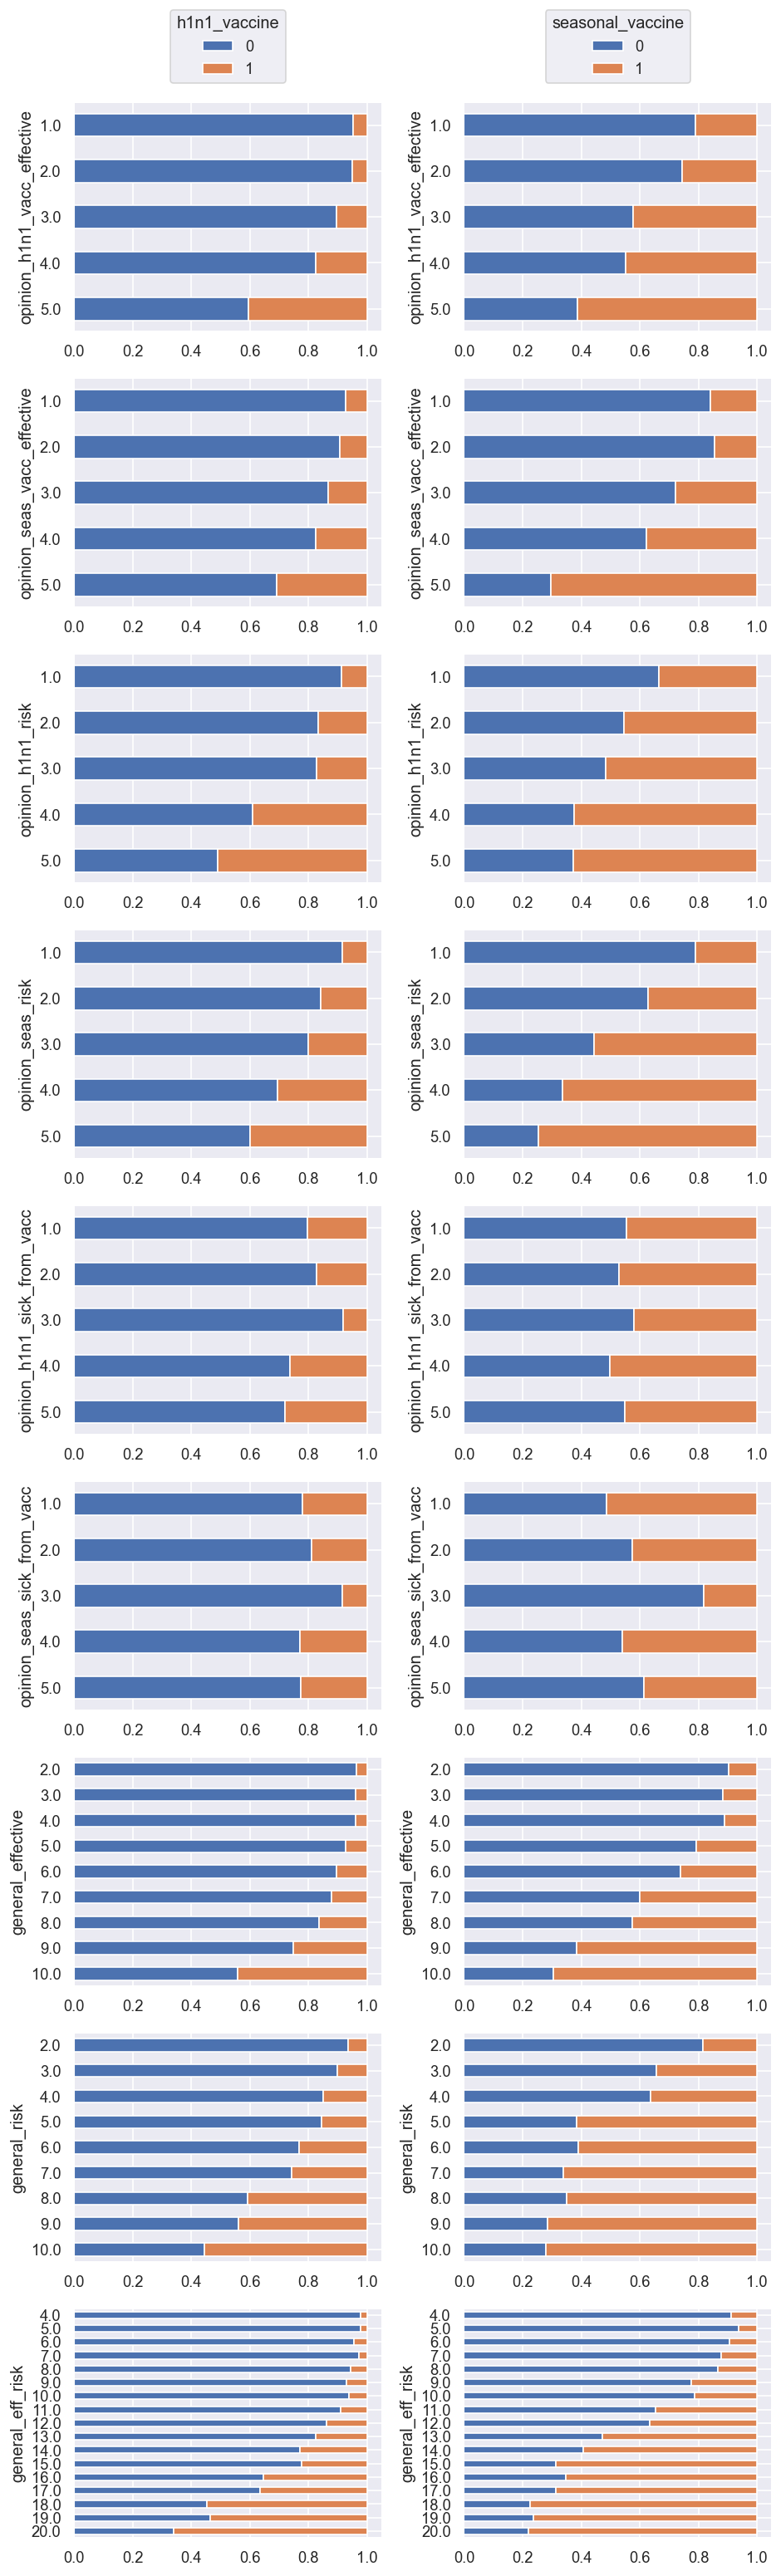

In [54]:
plot_bars(opinion_cols, figsize = (8, 26))

Regarding the opinions of the subjects about the diseases, we can see that both the perception about the effectiveness of the vaccine and the risk of contracting the disease not having taken the vaccine have a high correlation with the subject's decision to take the vaccines, both for the seasonal flu and the H1N1. On the other hand, the respondent's worry about getting sick from the vaccine does not correlate with their decision on taking the vaccines.

For these features we could form *general_effective*, *general_risk* and, their sum, *general_eff_risk* features in the same way we would form a *general_behaviour* feature - which also seem to be highly correlated with taking the vaccine.

In [47]:
doc_recc_cols = ['doctor_recc_h1n1',
                 'doctor_recc_seasonal']

In [48]:
train_df['general_reccomendation'] = train_df['doctor_recc_h1n1'] + train_df['doctor_recc_seasonal']
doc_recc_cols.append('general_reccomendation')

engineered_features.append('general_reccomendation')

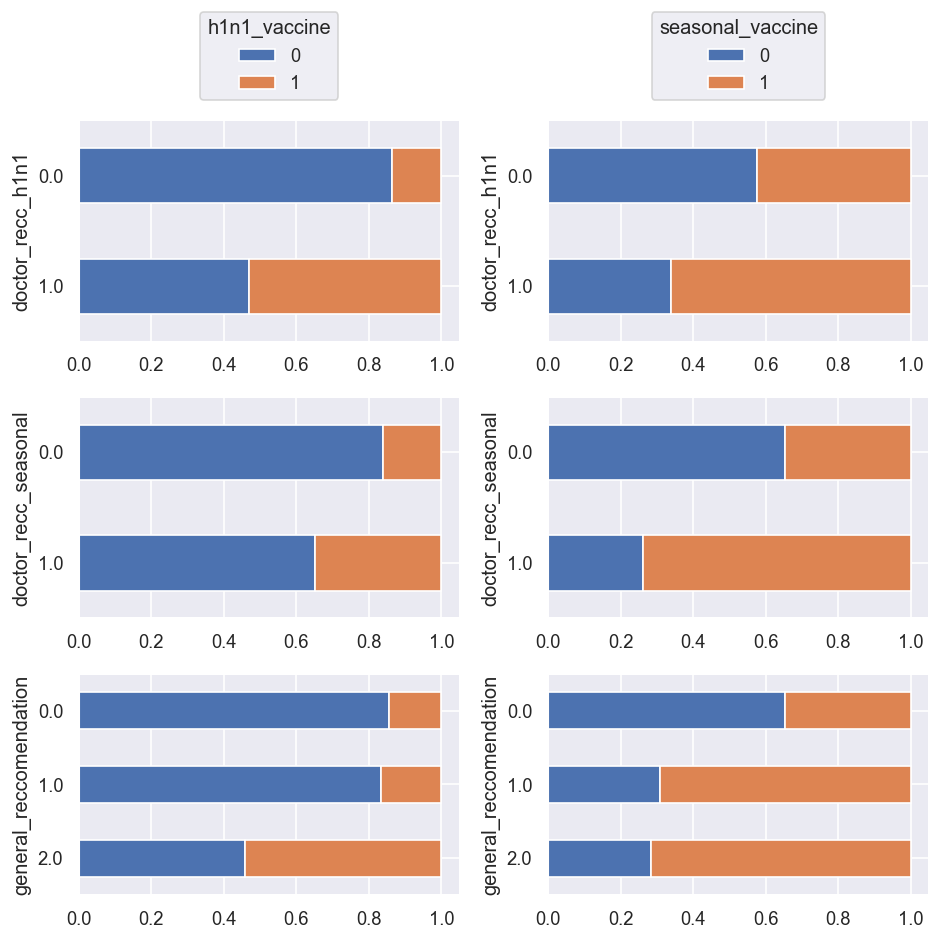

In [49]:
plot_bars(doc_recc_cols, figsize = (8, 8))

As expected, a doctor reccomendation to take the vaccine goes a long way in influencing the respondent's decision to take the vaccine. It can be seen that even when the doctor recommends one of the vaccines, it influences the person's decision to take the other. This could be due to the fact that a doctor is likely to recommend both vaccines, if he/she recommends one of them. This can be studied in a new feature *general_recommendation* which agreggates the recommendation of *both* vaccines, *one* of them or *none*.

In [58]:
h1n1_cols = ['h1n1_concern',
             'h1n1_knowledge']

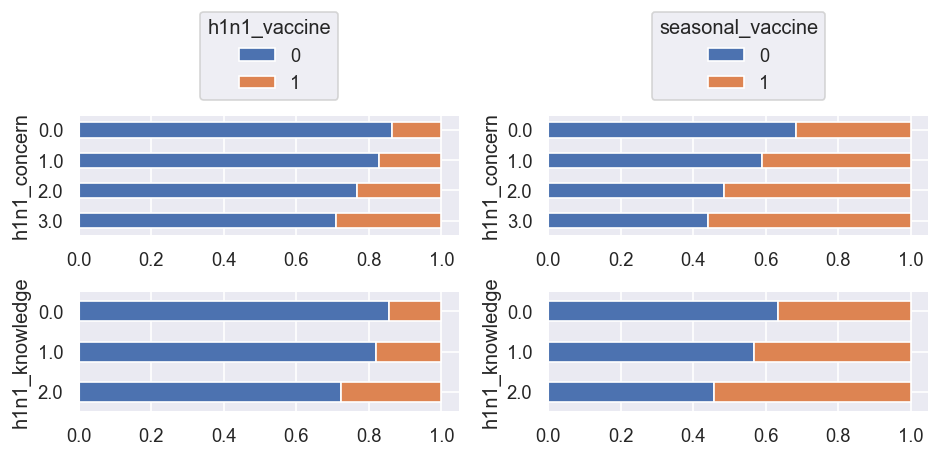

In [60]:
plot_bars(h1n1_cols, figsize = (8, 4))

Much like some of the other features above, the H1N1 concern and knowledge features are correlated with the subject taking the vaccine.

In [61]:
demographic_cols = ['household_adults',
                    'household_children',
                    'child_under_6_months']

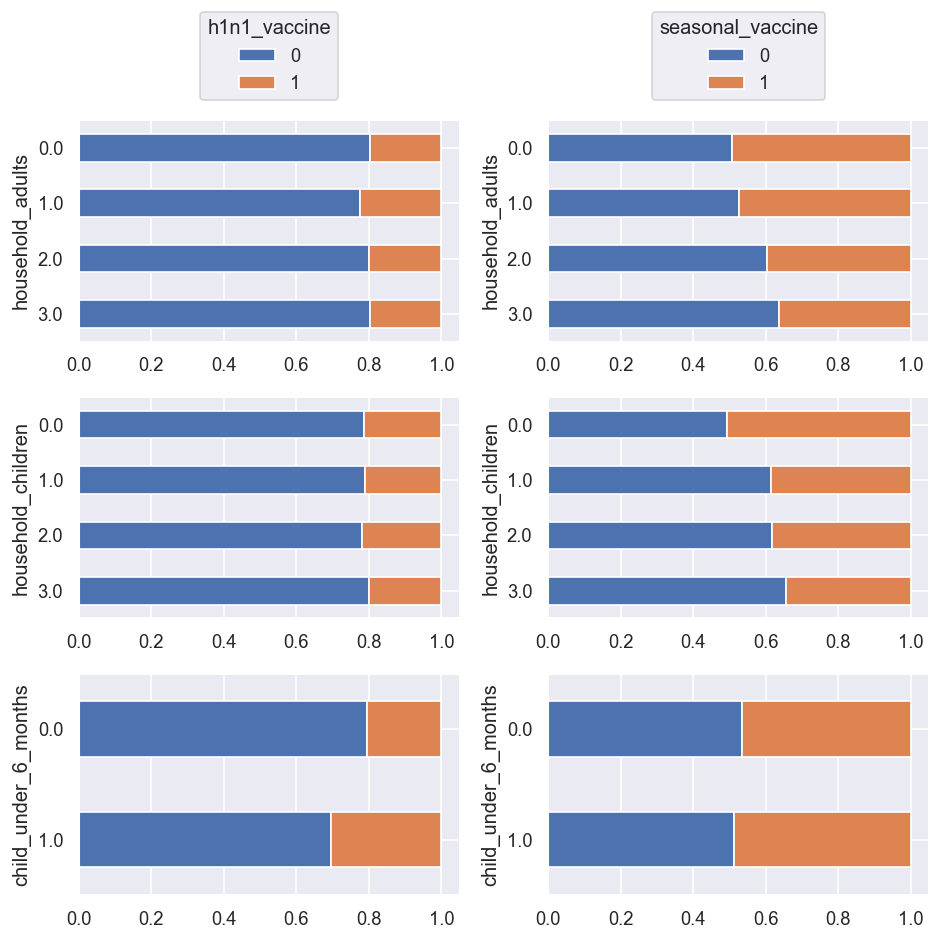

In [63]:
plot_bars(demographic_cols, figsize = (8, 8))

The demographic columns of household composition are not so related to the vaccines.

In [64]:
other_cols = ['chronic_med_condition',
              'health_worker',
              'health_insurance']

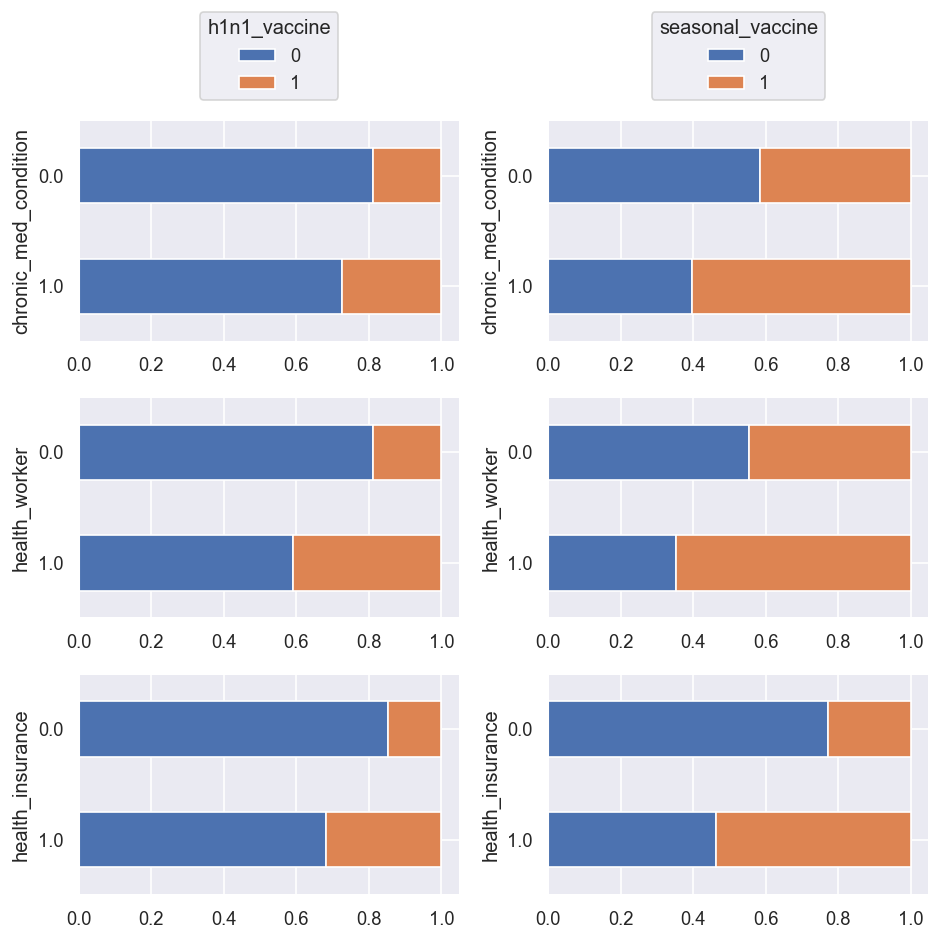

In [65]:
plot_bars(other_cols, figsize = (8, 8))

Finally, these *other* columns show a rather expected correlation between being a *health_worker* and having *health_insurance* and taking the vaccines, since they are more reccomended for the former and cheaper for the latter. A *chronic_med_condition* - which could be respiratory such as asthma - also makes someone more likely to take the vaccine.